In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

## Start hack to get Basemap to work while Prophet is also installed
## Do not change order of imports!
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap ## this has to come after the file hack above
import fbprophet ## this and the next line have to come after importing Basemap
from fbprophet import Prophet ## in this order
## end hack

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
import local
gmaps = googlemaps.Client(key=local.GOOGLE_MAP_API_KEY)
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style()

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.
0.20.0


In [2]:
zip_re = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')

In [3]:
numerics = zip_re.loc[:,'1996-04':'2018-09']
city_num = numerics
city_num = city_num.assign(city=zip_re.City)
groups = pd.melt(city_num, id_vars='city', var_name='month', value_name='price').groupby('city', as_index=False).agg({"price": "median"})
groups = groups.sort_values(by='price', ascending=False)
display('Top Median Price:', groups.head())
display('Bottom Median Price', groups.tail())

'Top Median Price:'

city      price
247           Atherton  3526200.0
5301        Palm Beach  2700400.0
6590  Snowmass Village  2445700.0
6374        Sea Island  2404100.0
4878     Newport Coast  2145350.0

'Bottom Median Price'

city    price
7801        Witt  25150.0
7697    Whitmire  25100.0
1899  Earlington  23500.0
5539    Pinewood  22650.0
4276      McColl  11400.0

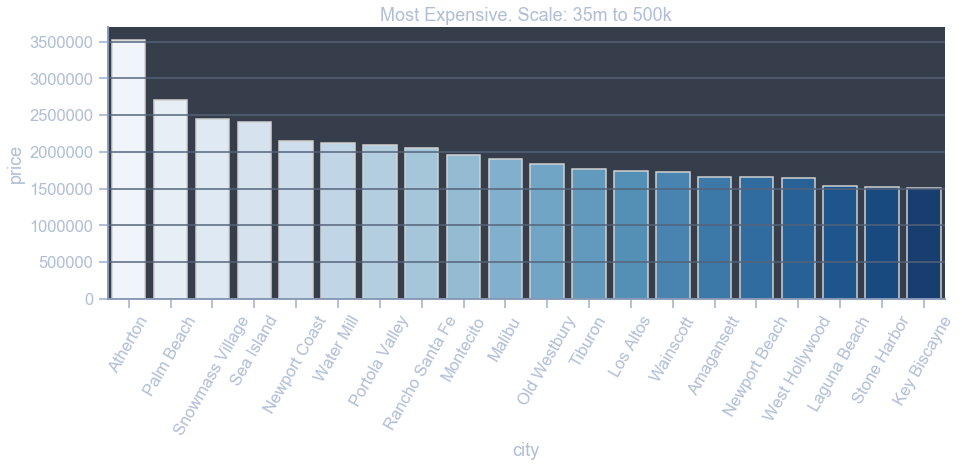

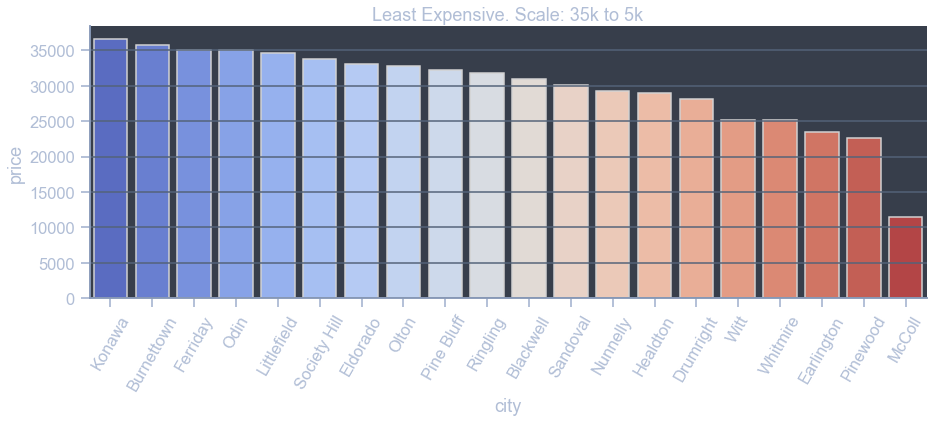

In [4]:
sns.set_context('talk')
top_20 = groups[:20]
bottom_20 = groups[-20:]
group_map = {'Most Expensive. Scale: 35m to 500k': top_20, 'Least Expensive. Scale: 35k to 5k': bottom_20}
palette = 'Blues'
for title, group in group_map.items():
    plt.figure(figsize=(15, 5))
    plt.title(title)
    sns.barplot(
        x=group.city, y=group.price,
        palette=sns.color_palette(palette, 20),
        ec='lightgray'
    )
    sns.despine()
    plt.xticks(rotation=60)
    plt.show()
    palette = 'coolwarm'

In [5]:
city_num = city_num.assign(metro=zip_re.Metro)
city_num = city_num.assign(state=zip_re.State)

In [6]:
def label_rural(x):
    if pd.isnull(x.metro):
        return f'Rural {x.state}'
    return x.metro
temp = city_num.apply(label_rural, axis=1)
city_num = city_num.assign(metro=temp)

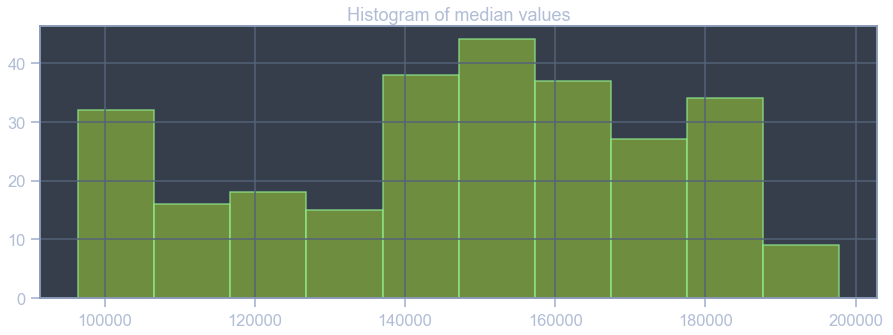

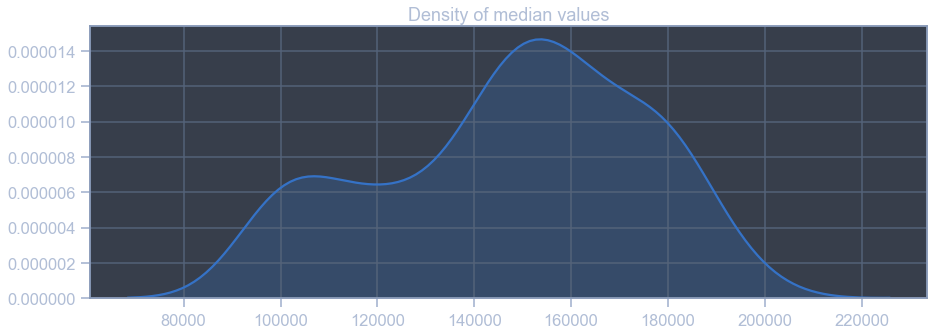

In [7]:
sns.set_context('talk')
city_median = city_num.median()
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

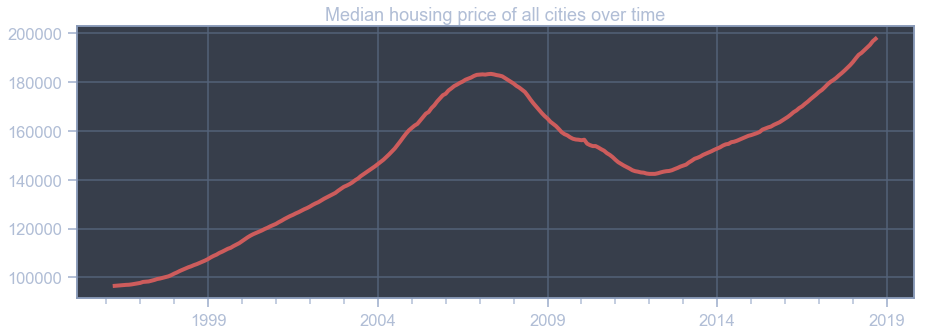

In [8]:
sns.set_context('talk')
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all cities over time')
plt.show()


	Logarithm of individual city housing prices by date per metro area



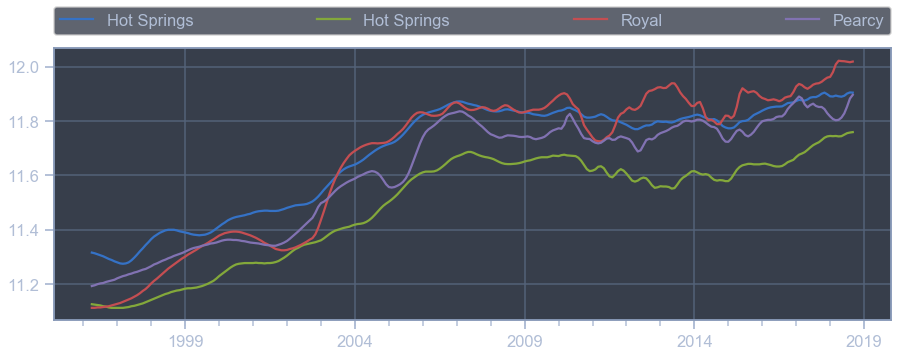

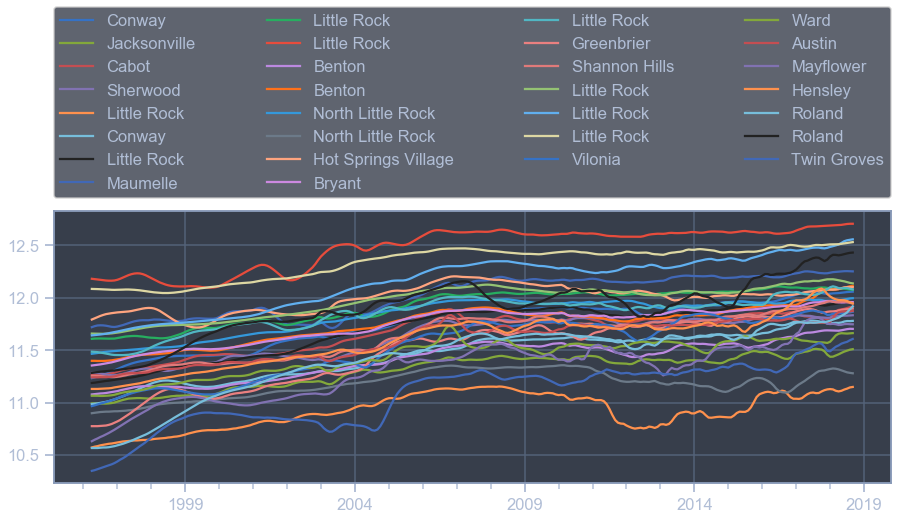

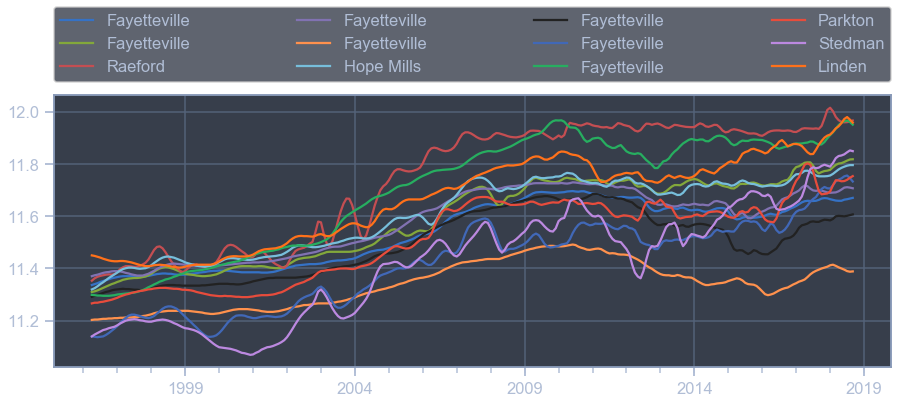

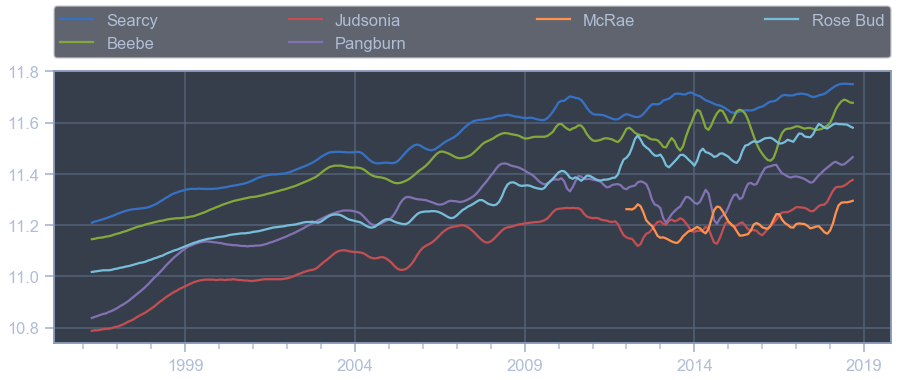

In [9]:

sns.set_context('talk')
names = ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
hot_springs = city_num.loc[city_num.metro == 'Hot Springs']
little_rock = city_num.loc[city_num.metro == 'Little Rock-North Little Rock-Conway']
fayetteville = city_num.loc[city_num.metro == 'Fayetteville']
searcy = city_num.loc[city_num.metro == 'Searcy']
arkansas = [hot_springs, little_rock, fayetteville, searcy]
metro_medians = {}
print('\n\tLogarithm of individual city housing prices by date per metro area\n')
for idx, df in enumerate(arkansas):
    df.drop(['metro', 'state'], axis=1, inplace=True)
    df.set_index('city', inplace=True)
    df.index.rename('date', inplace=True)
    metro_medians[names[idx]] = df.median()
    df = df.T
    df.index = pd.to_datetime(df.index)
    np.log(df).plot(figsize=(15, 5))
    plt.legend(bbox_to_anchor=(0., 1.05, 1., .0), loc=3, ncol=4, mode='expand', borderaxespad=0.)
    plt.show()


	Median housing price by date per metro area



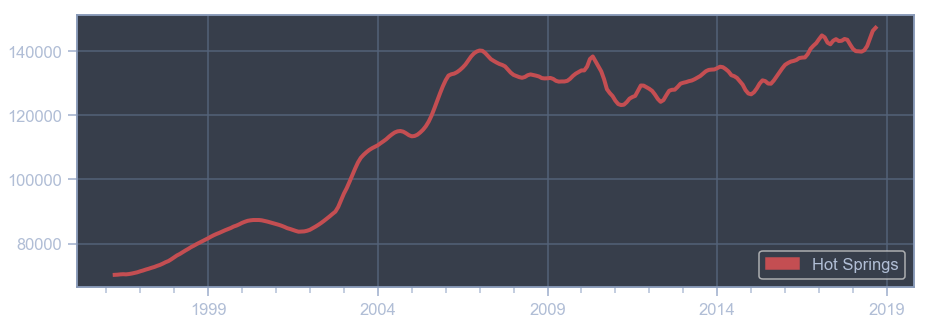

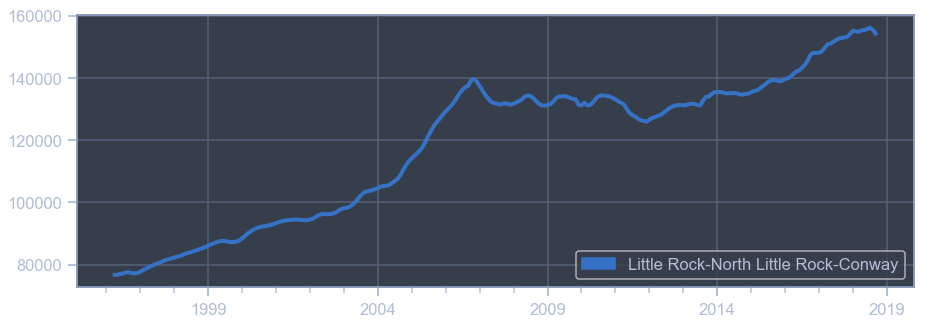

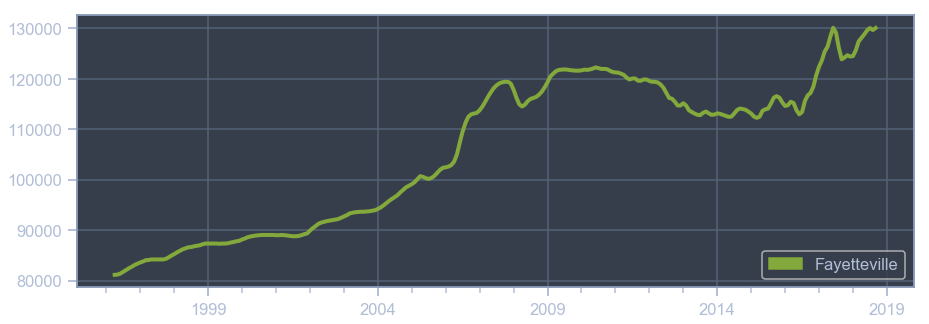

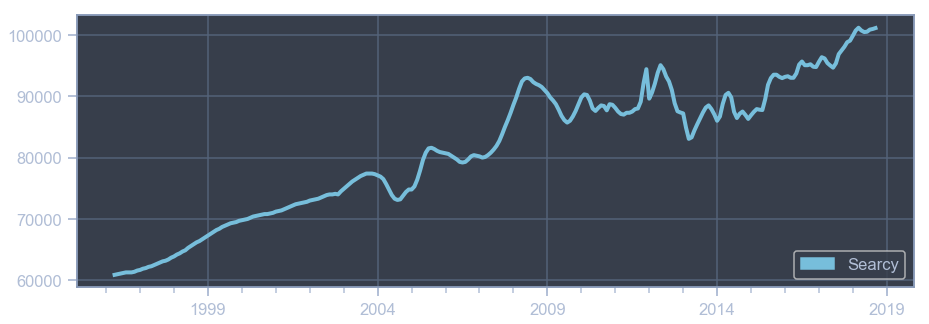

In [10]:
# reference names ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
sns.set_context('talk')
colors = {
    'r': 'Hot Springs',
    'b': 'Little Rock-North Little Rock-Conway',
    'g': 'Fayetteville',
    'c': 'Searcy',
}
idx = 0
print('\n\tMedian housing price by date per metro area\n')
for k, v in colors.items():
    df = metro_medians[v]
    df.index = pd.to_datetime(df.index)
    df.plot(
        figsize=(15, 5), 
        color=k,
        linewidth=4
    )
    plt.legend(
        loc=4,
        handles=[mpatches.Patch(color=k, label=v)]
    )
    idx += 1
    plt.show()

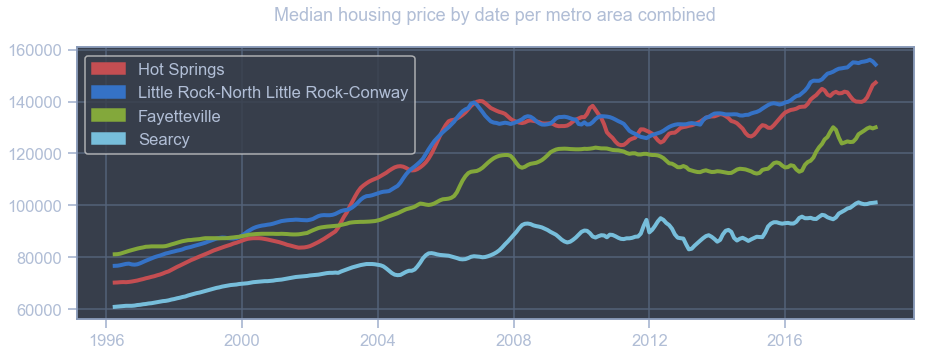

In [11]:
# reference names ['Hot Springs', 'Little Rock-North Little Rock-Conway', 'Fayetteville', 'Searcy']
sns.set_context('talk')
handles = []
plt.figure(figsize=(15, 5))
for k, v in colors.items():
    sns.lineplot(data=metro_medians[v], color=k, linewidth=4)
    handles.append(mpatches.Patch(color=k, label=v))
plt.legend(handles=[handle for handle in handles])
plt.title('Median housing price by date per metro area combined\n')
plt.show()

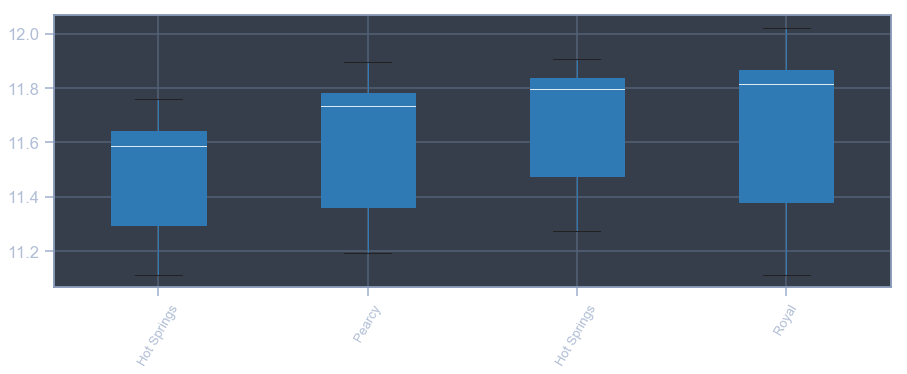

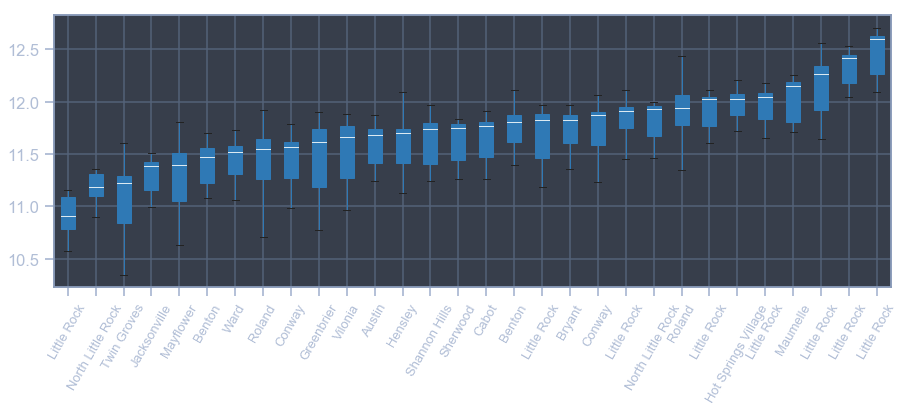

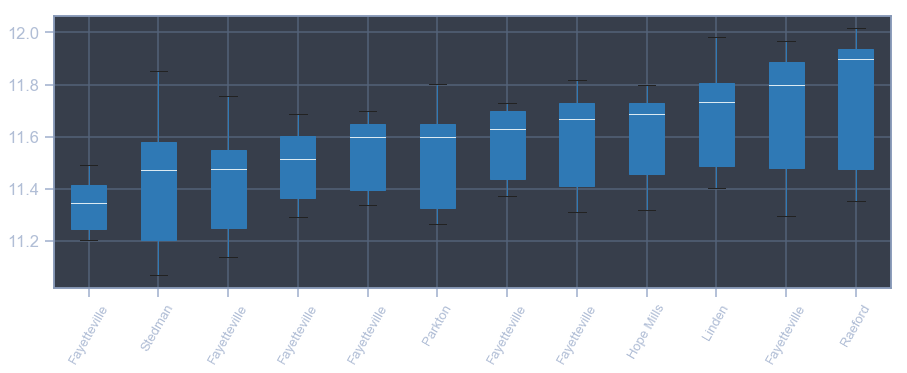

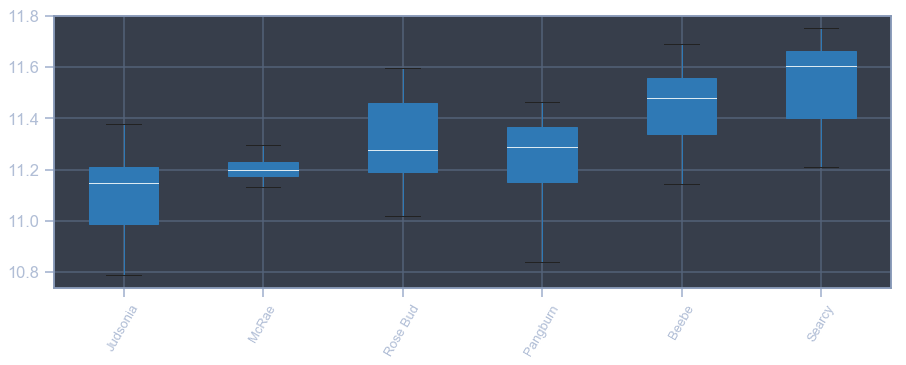

In [12]:
for df in arkansas:
    df = df.assign(median=df.median(axis=1))
    df.sort_values(by='median', inplace=True)
    sns.set_context('talk')
    sns.set_palette('RdBu_r')
    df.index.rename('city', inplace=True)
    np.log(df.T).plot(kind='box', figsize=(15, 5), patch_artist=True)
    plt.xticks(rotation=60, fontsize=13)
    plt.show()
    df.drop('median', axis=1)

In [13]:
from statsmodels.tsa.stattools import adfuller
sns.set_context('talk')
def test_stationarity(name: str, timeseries: pd.Series):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15, 5))
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

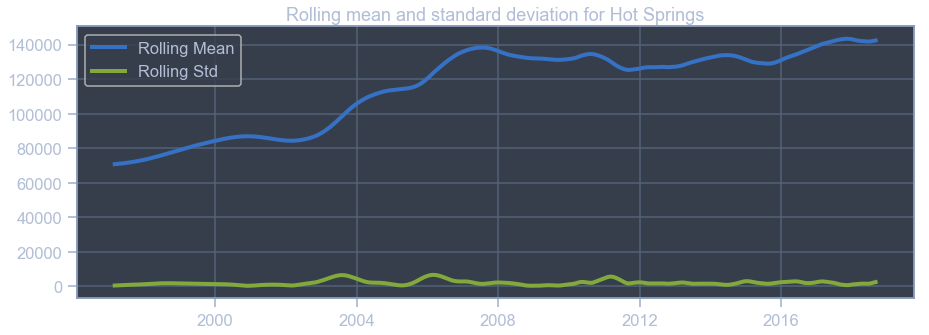

'Hot Springs AD Fuller test results'

Test Statistic       -1.466830
p-value               0.549852
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

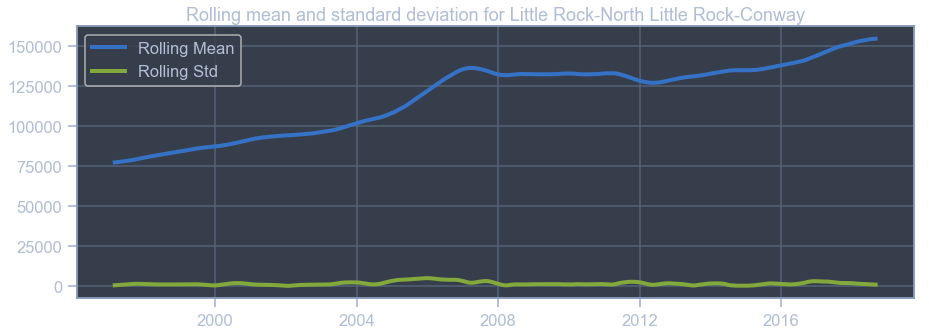

'Little Rock-North Little Rock-Conway AD Fuller test results'

Test Statistic       -1.287863
p-value               0.634707
Critical Value 1%    -3.455365
Critical Value 5%    -2.872551
Critical Value 10%   -2.572638
dtype: float64

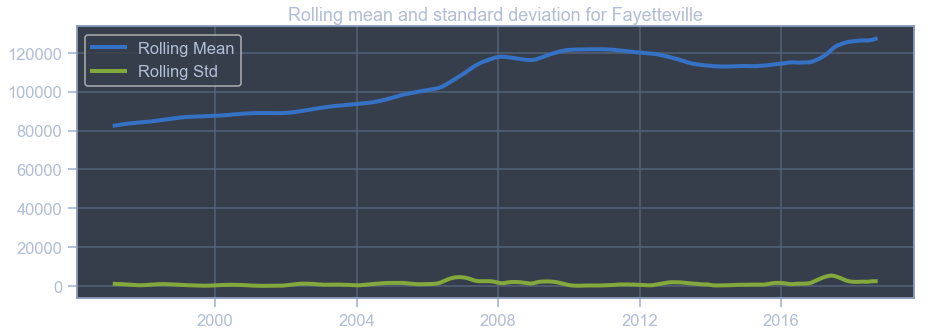

'Fayetteville AD Fuller test results'

Test Statistic       -0.847313
p-value               0.804828
Critical Value 1%    -3.456464
Critical Value 5%    -2.873033
Critical Value 10%   -2.572895
dtype: float64

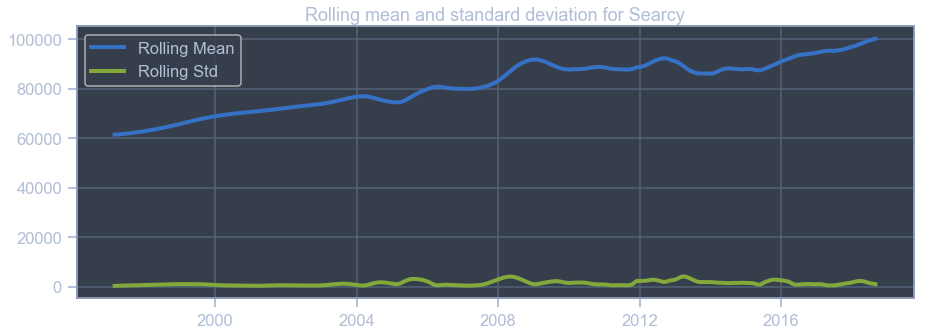

'Searcy AD Fuller test results'

Test Statistic       -0.888363
p-value               0.791781
Critical Value 1%    -3.455081
Critical Value 5%    -2.872427
Critical Value 10%   -2.572571
dtype: float64

In [14]:
def test_show_ad(data: dict):
    ad_tests = {}
    for name, timeseries in data.items():
        display(f'{name} AD Fuller test results', test_stationarity(name, timeseries))
test_show_ad(metro_medians)

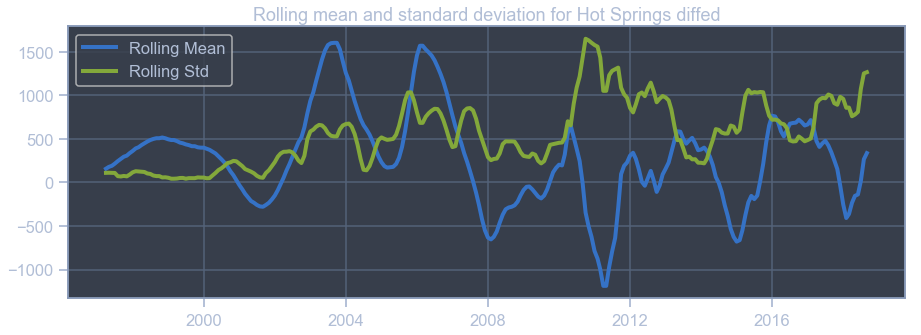

'Hot Springs diffed AD Fuller test results'

Test Statistic       -4.007697
p-value               0.001371
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

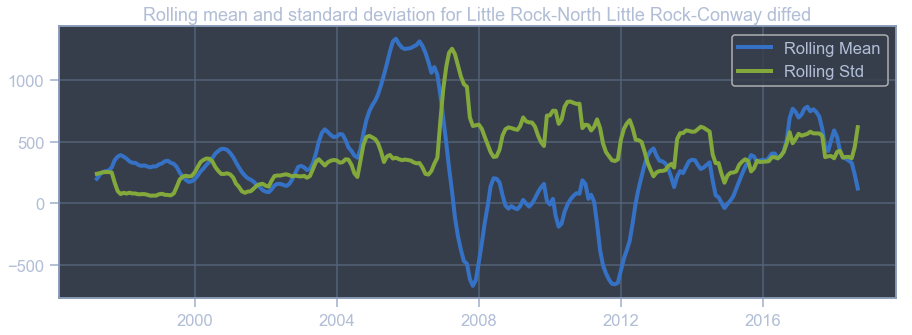

'Little Rock-North Little Rock-Conway diffed AD Fuller test results'

Test Statistic       -5.097410
p-value               0.000014
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

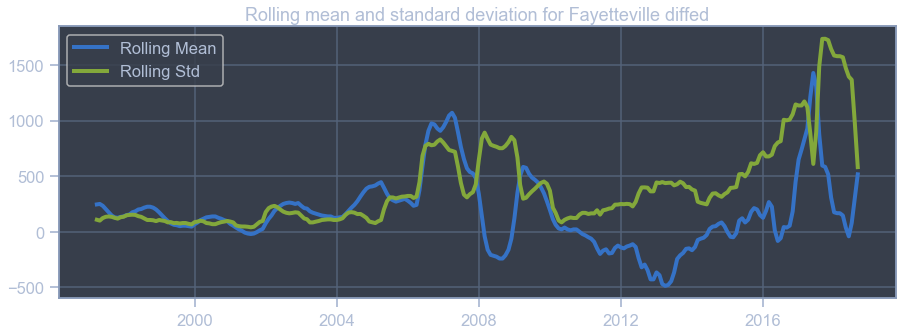

'Fayetteville diffed AD Fuller test results'

Test Statistic       -3.257483
p-value               0.016889
Critical Value 1%    -3.456464
Critical Value 5%    -2.873033
Critical Value 10%   -2.572895
dtype: float64

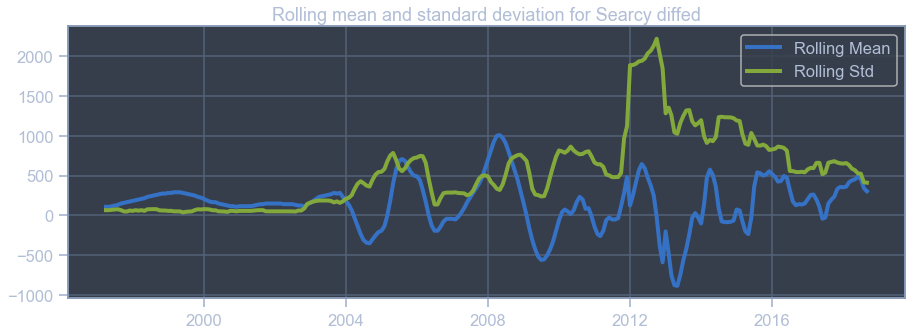

'Searcy diffed AD Fuller test results'

Test Statistic       -1.006330e+01
p-value               1.316138e-17
Critical Value 1%    -3.455081e+00
Critical Value 5%    -2.872427e+00
Critical Value 10%   -2.572571e+00
dtype: float64

In [15]:
metro_diffed = {}
for name, timeseries in metro_medians.items():
    diff = timeseries.diff()
    diff.dropna(inplace=True)
    name = f'{name} diffed'
    metro_diffed[name] = diff
test_show_ad(metro_diffed)

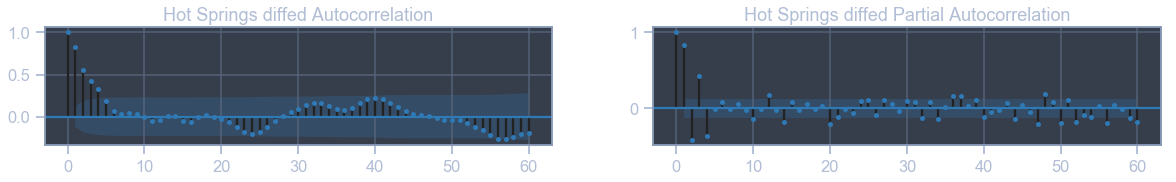

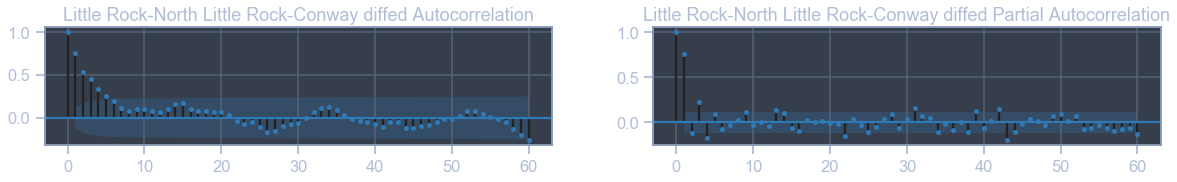

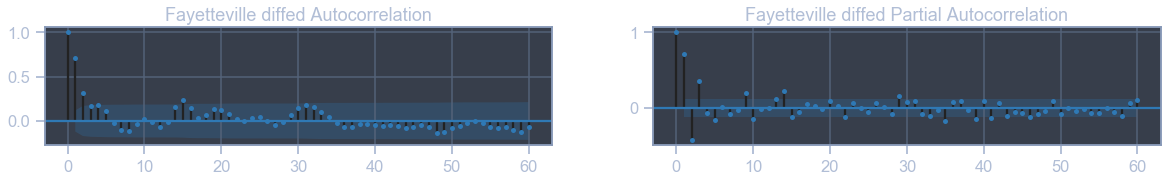

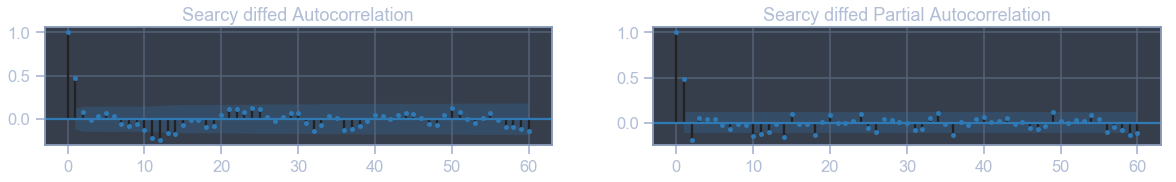

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
counter = 421
for name, df in metro_diffed.items():
    plt.figure(figsize=(20, 10))
    plt.subplot(counter); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    counter += 1
    plt.subplot(counter); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')
    counter += 1

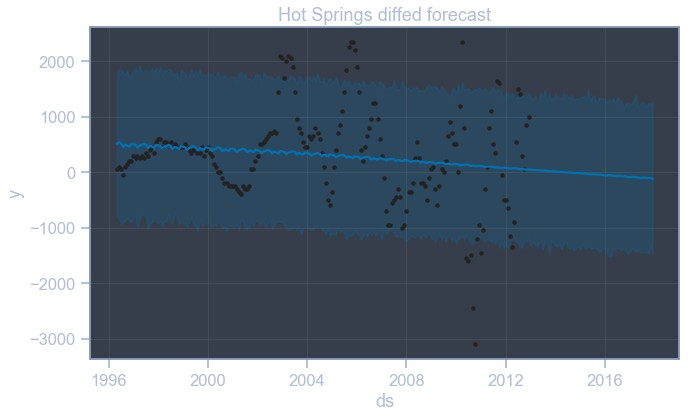

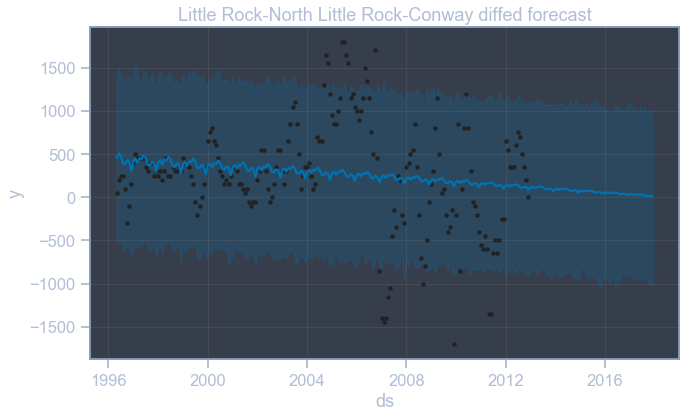

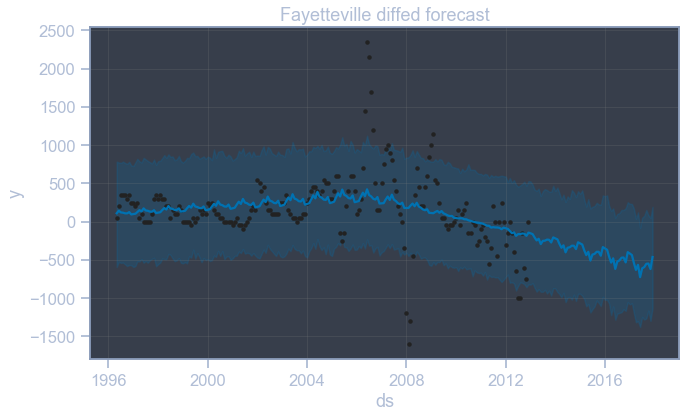

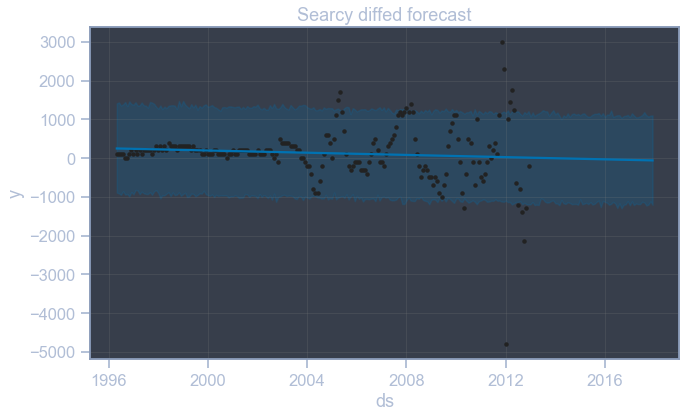

In [17]:
forecasts = {}
for name, df in metro_diffed.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df[:'2012'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*5, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

In [18]:
undiff_acc = {}
for name, df in metro_medians.items():
    temp = df.loc[df.index >  '2013']
    temp_2018 = temp.loc[temp.index < '2018']
    undiff_pred = np.r_[
        temp_2018.iloc[0],
        forecasts[f'{name} diffed forecast'].loc[
            pd.to_datetime(forecasts[f'{name} diffed forecast'].ds) > '2013'
        ].yhat.iloc[1:]].cumsum()
    undiff_acc[name] = pd.DataFrame({
        'actual': temp_2018,
        'predicted': undiff_pred,
        'error': np.absolute(undiff_pred - temp_2018)
    })

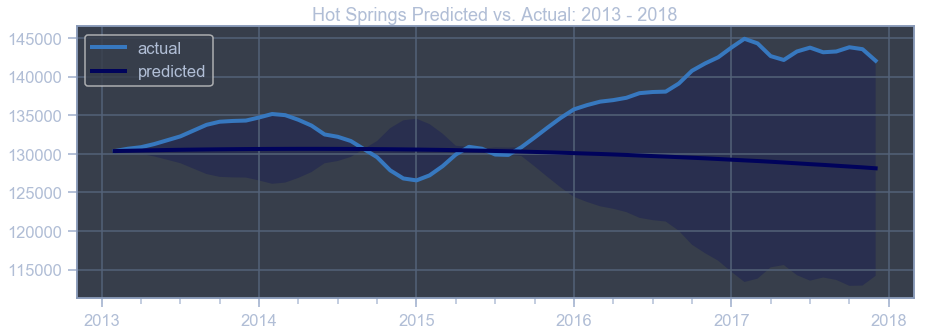

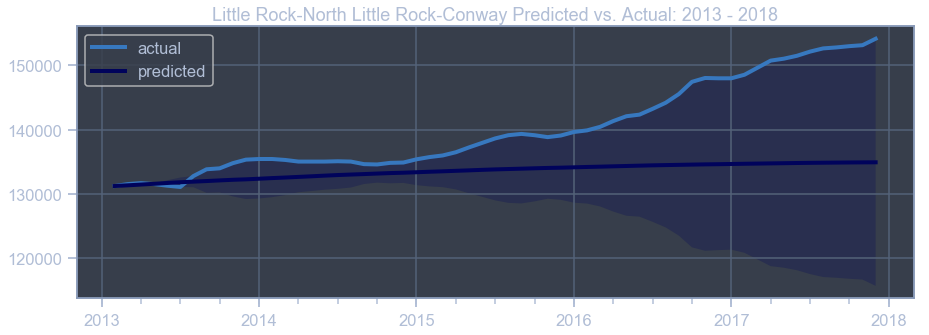

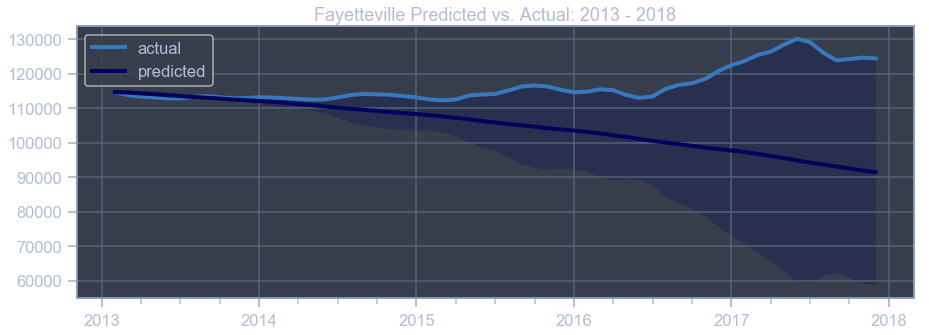

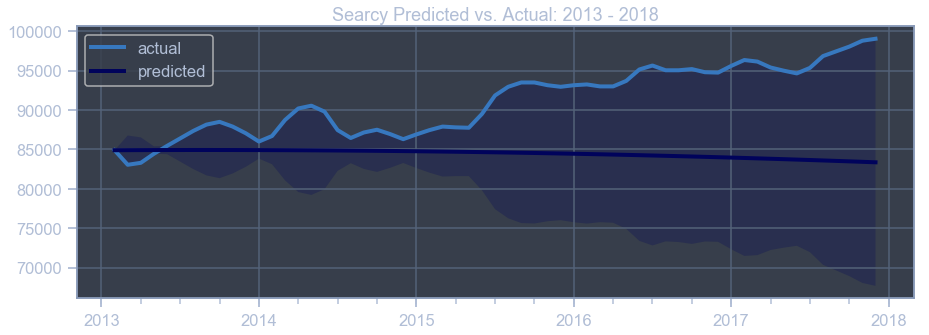

In [19]:
flatui = [
    sns.xkcd_rgb['windows blue'], 
    sns.xkcd_rgb['dark blue'],
]
def map_prediction_errors(data: dict):
    for name, df in data.items():
        sns.set_palette(flatui)
        df.drop('error', axis=1).plot(linewidth=4, figsize=(15, 5))
        x = df.index
        y = df.predicted
        error = df.error
        plt.fill_between(x, y-error, y+error, alpha=0.25, facecolor=flatui[1])
        plt.title(f'{name} Predicted vs. Actual: 2013 - 2018')
        plt.show()
map_prediction_errors(undiff_acc)

In [20]:
zip_num = numerics
zip_num = zip_num.assign(date_index=zip_re.RegionName) # <-- c'mon Zillow, that's a dumb name for a zip code variable
zip_num = zip_num.set_index('date_index').T
zip_num.index = pd.to_datetime(zip_num.index)
city_num = city_num.assign(zip_code=zip_re.RegionName)

In [21]:
"""
The offset and count here determine how many responses we get back
as a recommendation. The offset is the highest median housing value 
that we would like to focus on -- example, setting offset to 150,000
means grind() only returns zip codes with medians under that.
The count is a static value that is used below in the sort and head
functionality. A smaller count will return fewer values from grind()
"""
def grind(offset, count):
    workset = zip_num.loc['2001':]
    temp = workset['2018'].T
    workset = workset[temp.loc[
        temp.median(axis=1) < offset ## oy
    ].T.columns.values]
    five_set = workset.loc['2009': '2014']
    ten_set = workset.loc['2004': '2014']
    def find_largest_increase(dataframe):
        result = {}
        result['gross'] = dataframe.apply(lambda x: x.max() - x.min(), axis=0)
        result['percent'] = dataframe.apply(lambda x: (x.max() - x.min()) / x.min(), axis=0)
        result = pd.DataFrame.from_dict(result).reset_index()
        result.columns = ['zip', 'gross', 'percent']
        return result
    five_raise = find_largest_increase(five_set)
    ten_raise = find_largest_increase(ten_set)
    top_percent = list(
        set(five_raise.sort_values(by='percent', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='percent', ascending=False).head(count).zip.values)
    )
    top_gross = list(
        set(five_raise.sort_values(by='gross', ascending=False).head(count).zip.values) \
        & set(ten_raise.sort_values(by='gross', ascending=False).head(count).zip.values)
    )
    return [zip_code for zip_code in top_percent if zip_code in top_gross]

In [22]:
full = grind(150e3, round(zip_num.shape[1] * .005)) ## this returns 10 values at time of publishing
full_monty = zip_re.loc[zip_re.RegionName.isin(full)]
drop = ['SizeRank', 'RegionID', 'CountyName']
full_monty.drop(drop, axis=1, inplace=True)
full_monty = full_monty.assign(
    zip_code=full_monty.RegionName, 
    city=full_monty.City, 
    state=full_monty.State,
    metro=full_monty.Metro
)
full_monty.drop(['RegionName', 'City', 'State', 'Metro'], axis=1, inplace=True)
high_zip = zip_num[full]
high_zip.shape

(270, 10)

In [23]:
"""
This takes a second and makes about 10 calls to the Google Maps API.
"""
geocode_results = {}
for zip_code in list(high_zip):
    temp = full_monty.loc[full_monty.zip_code == zip_code]
    temp = temp.drop(full_monty.columns[range(0, 249)], axis=1)
    temp = temp.drop(['zip_code', 'city', 'state', 'metro'], axis=1)
    name = full_monty.loc[full_monty.zip_code == zip_code, 'city'].values[0]
    increase = (temp.T.iloc[-1] - temp.T.iloc[0]).values[0]
    zip_code = str(zip_code)
    
    if len(zip_code) < 5:
        zip_code = f'0{zip_code}'
        
    geocode = gmaps.geocode(zip_code)[0]
    geocode_results[name] = {
        'increase' : increase,
        'zip': zip_code,
        'lng': geocode['geometry']['location']['lng'],
        'lat': geocode['geometry']['location']['lat'],
    }

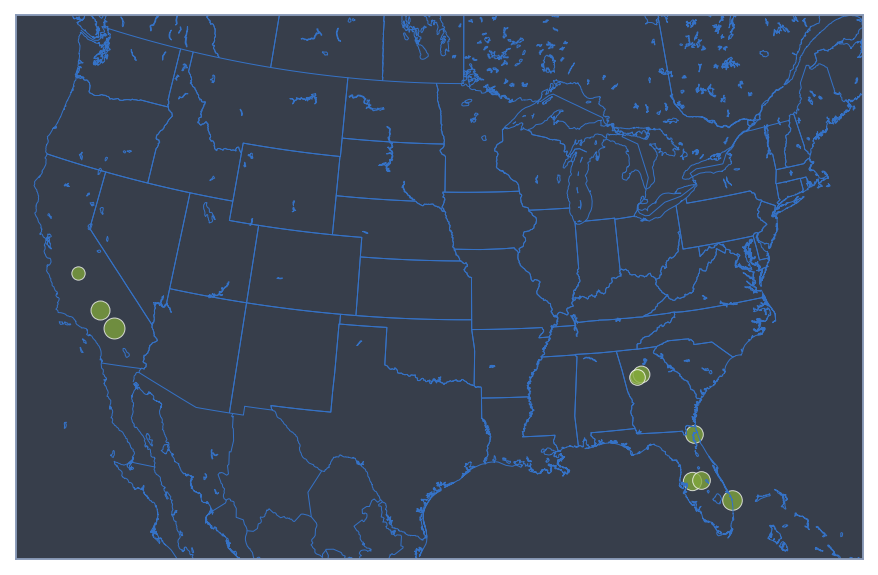

In [24]:
## this takes 20 - 30 seconds. to speed it up 
## change the 'resolution' value in the Basemap constructor to 'c' (for crude)
plt.figure(figsize=(20, 10))
m = Basemap(
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    projection='lcc', 
    lat_1=33,
    lat_2=45,
    lon_0=-95,
    resolution='i' ## oy!
)
gray = 'b'
m.drawcoastlines(color=gray, linewidth=1)
m.drawstates(color=gray, linewidth=1)
m.drawcountries(color=gray, linewidth=1)
for city in geocode_results.items():
    x, y = m(city[1]['lng'], city[1]['lat'])
    m.scatter(
        x, y, 
        color='g', 
        s=city[1]['increase'] * .01, 
        alpha=.75,
        edgecolor='white',
        linewidth=1
    )
plt.show()

In [25]:
print('Increased value in the "simple algorithmic" recommended areas from January 2017 to September 2018')
display(pd.DataFrame.from_dict(geocode_results).loc[['zip', 'increase']].T.sort_values(by='increase', ascending=False))
print(u'\u2B06', 'Fresno: The Armpit of California')

Increased value in the "simple algorithmic" recommended areas from January 2017 to September 2018


zip increase
Lucerne Valley   92356    43900
Riviera Beach    33404    38500
California City  93505    36100
Plant City       33563    33600
Dundee           33838    31300
Jacksonville     32211    31100
Panthersville    30034    28200
Union City       30291    24600
Riverdale        30349    19400
Fresno           93706    17800

⬆ Fresno: The Armpit of California


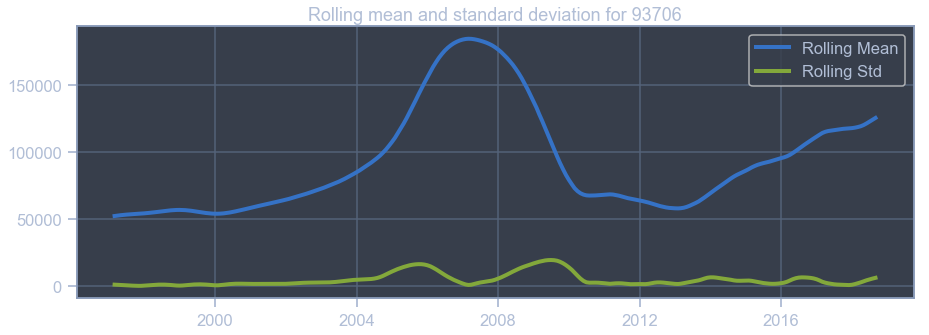

'93706 AD Fuller test results'

Test Statistic       -2.353052
p-value               0.155428
Critical Value 1%    -3.456464
Critical Value 5%    -2.873033
Critical Value 10%   -2.572895
dtype: float64

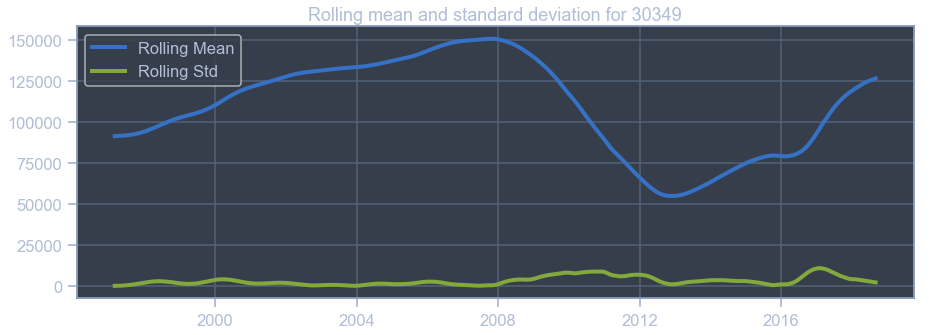

'30349 AD Fuller test results'

Test Statistic       -2.413138
p-value               0.138063
Critical Value 1%    -3.455656
Critical Value 5%    -2.872678
Critical Value 10%   -2.572705
dtype: float64

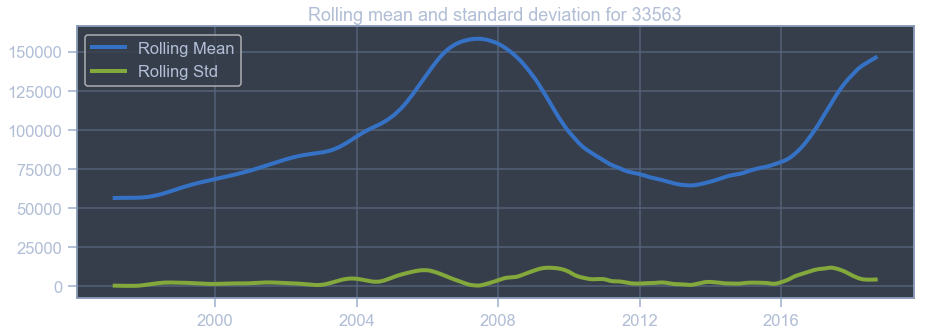

'33563 AD Fuller test results'

Test Statistic       -2.728979
p-value               0.069157
Critical Value 1%    -3.455558
Critical Value 5%    -2.872636
Critical Value 10%   -2.572683
dtype: float64

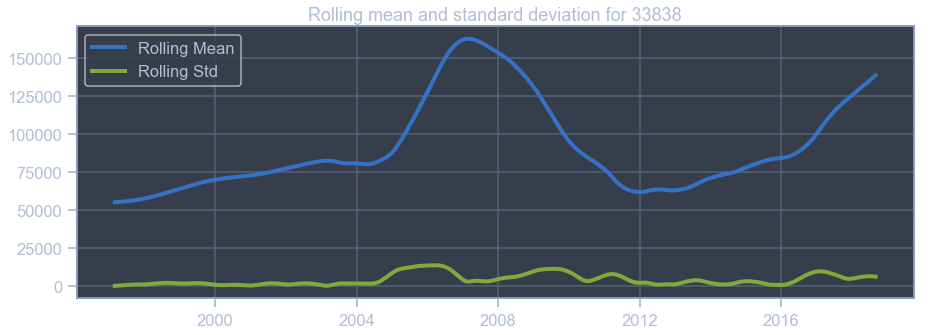

'33838 AD Fuller test results'

Test Statistic       -2.905449
p-value               0.044718
Critical Value 1%    -3.456054
Critical Value 5%    -2.872853
Critical Value 10%   -2.572799
dtype: float64

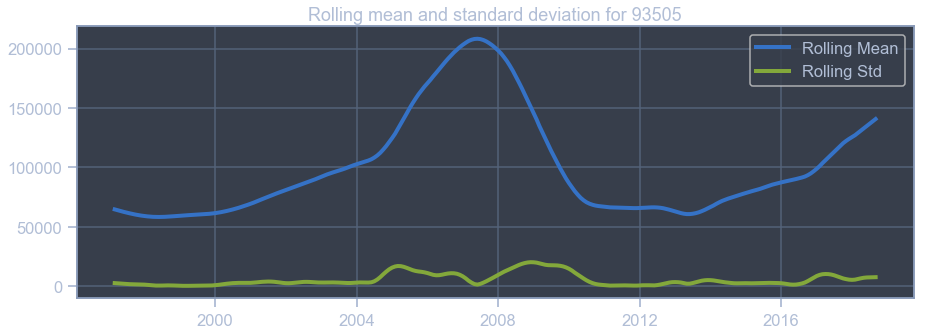

'93505 AD Fuller test results'

Test Statistic       -2.955986
p-value               0.039214
Critical Value 1%    -3.455754
Critical Value 5%    -2.872721
Critical Value 10%   -2.572728
dtype: float64

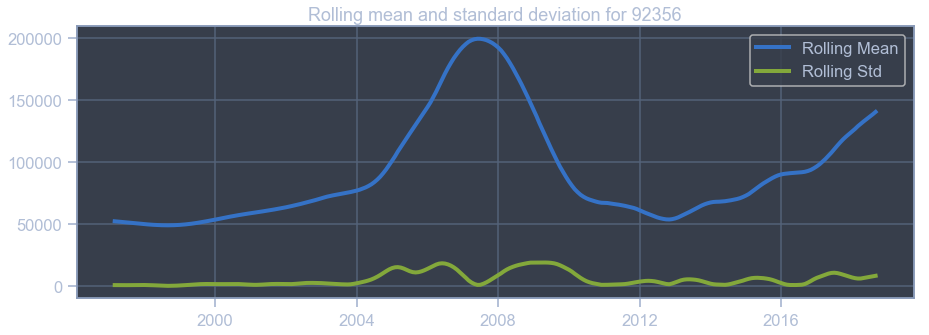

'92356 AD Fuller test results'

Test Statistic       -2.635015
p-value               0.085974
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

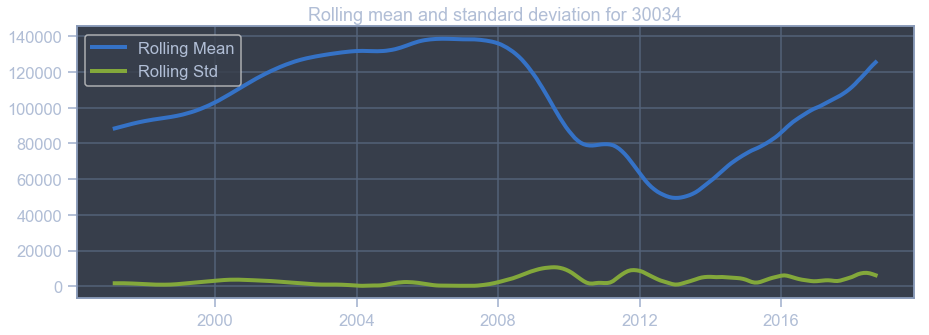

'30034 AD Fuller test results'

Test Statistic       -2.166283
p-value               0.218709
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

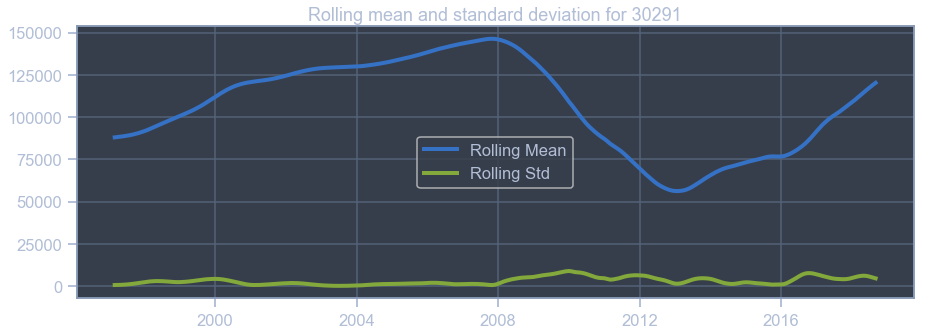

'30291 AD Fuller test results'

Test Statistic       -2.385962
p-value               0.145738
Critical Value 1%    -3.455656
Critical Value 5%    -2.872678
Critical Value 10%   -2.572705
dtype: float64

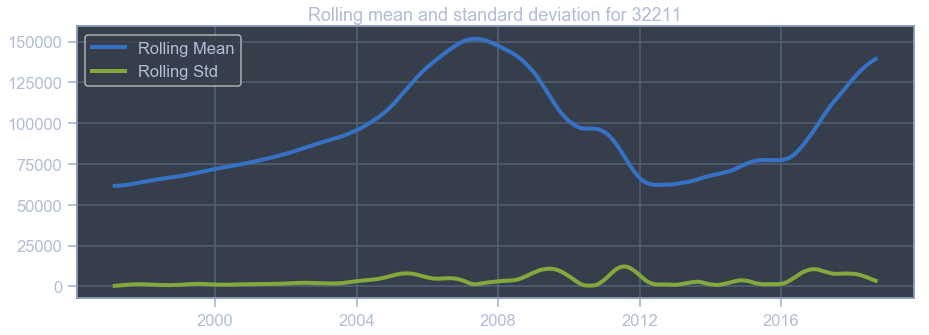

'32211 AD Fuller test results'

Test Statistic       -2.888455
p-value               0.046707
Critical Value 1%    -3.456360
Critical Value 5%    -2.872987
Critical Value 10%   -2.572870
dtype: float64

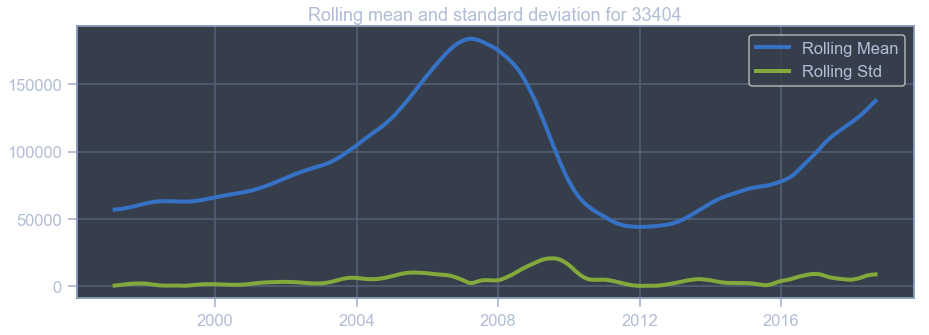

'33404 AD Fuller test results'

Test Statistic       -2.791302
p-value               0.059527
Critical Value 1%    -3.456360
Critical Value 5%    -2.872987
Critical Value 10%   -2.572870
dtype: float64

In [26]:
test_show_ad(high_zip)

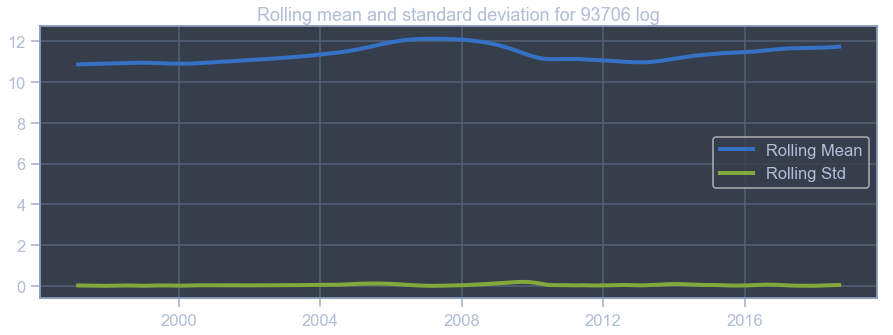

'93706 log AD Fuller test results'

Test Statistic       -2.209423
p-value               0.202843
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

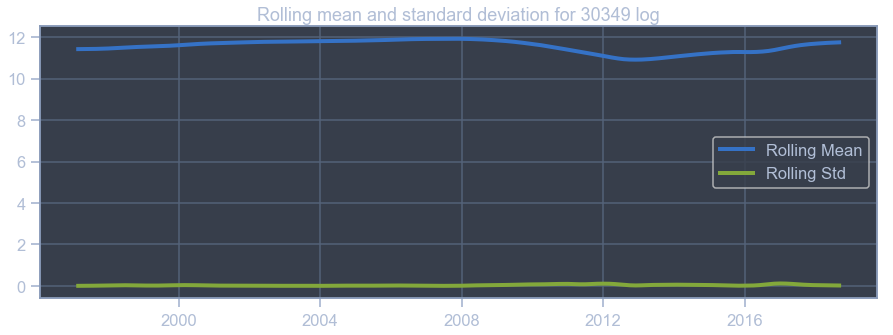

'30349 log AD Fuller test results'

Test Statistic       -2.801768
p-value               0.058022
Critical Value 1%    -3.456360
Critical Value 5%    -2.872987
Critical Value 10%   -2.572870
dtype: float64

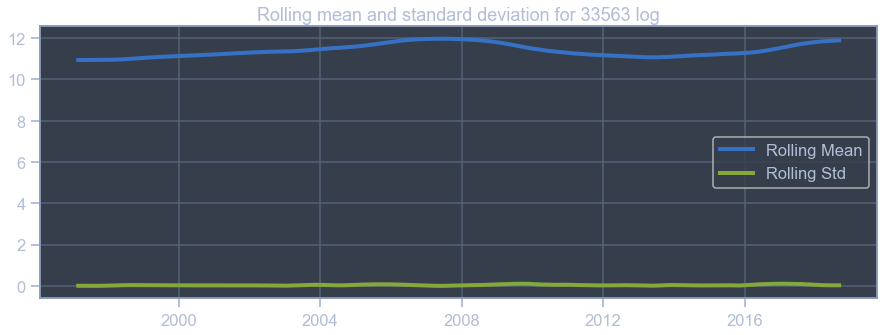

'33563 log AD Fuller test results'

Test Statistic       -2.635762
p-value               0.085829
Critical Value 1%    -3.455558
Critical Value 5%    -2.872636
Critical Value 10%   -2.572683
dtype: float64

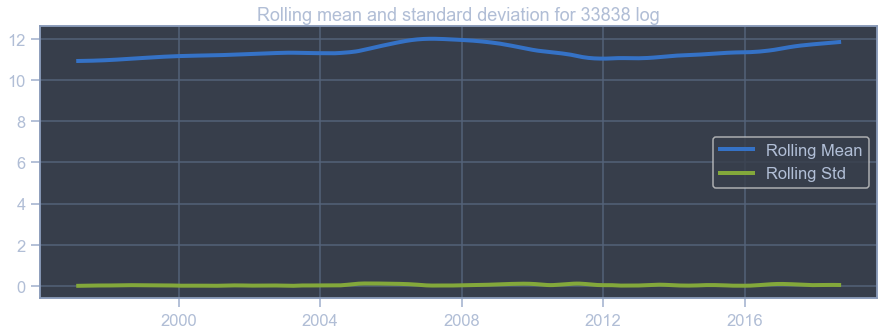

'33838 log AD Fuller test results'

Test Statistic       -2.821840
p-value               0.055221
Critical Value 1%    -3.456054
Critical Value 5%    -2.872853
Critical Value 10%   -2.572799
dtype: float64

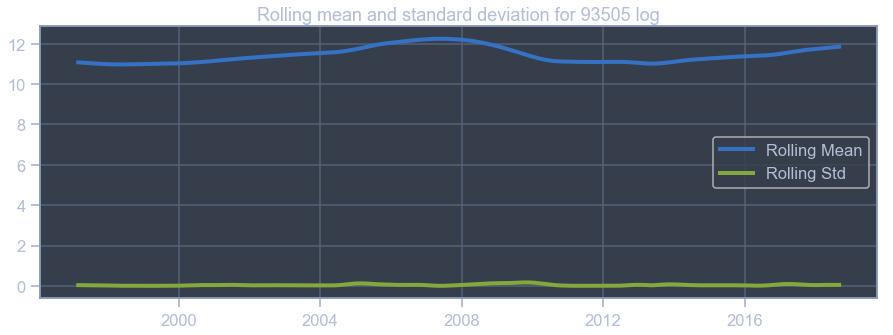

'93505 log AD Fuller test results'

Test Statistic       -3.150330
p-value               0.023046
Critical Value 1%    -3.456360
Critical Value 5%    -2.872987
Critical Value 10%   -2.572870
dtype: float64

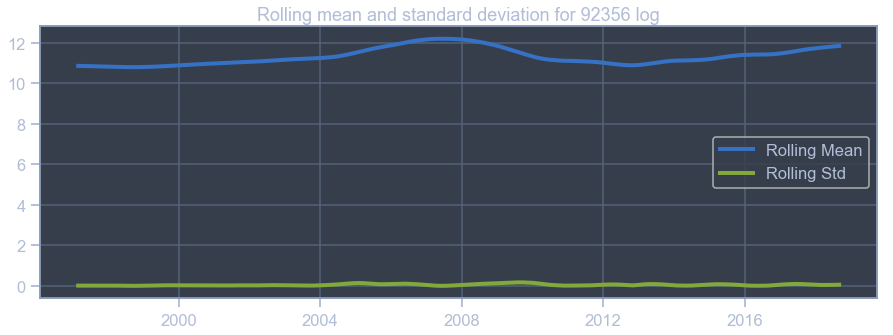

'92356 log AD Fuller test results'

Test Statistic       -2.579230
p-value               0.097366
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

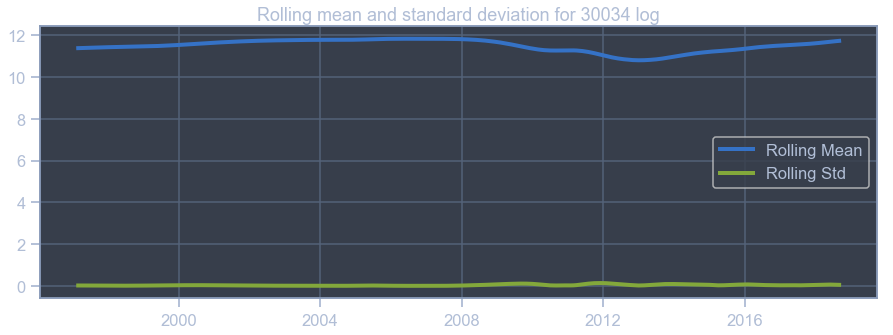

'30034 log AD Fuller test results'

Test Statistic       -2.121558
p-value               0.235935
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

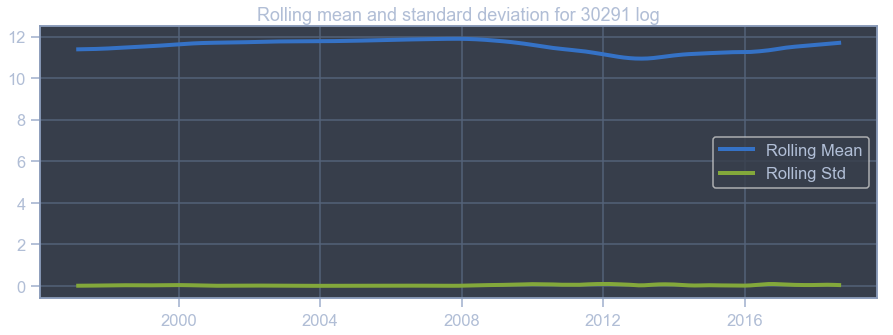

'30291 log AD Fuller test results'

Test Statistic       -2.073023
p-value               0.255500
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

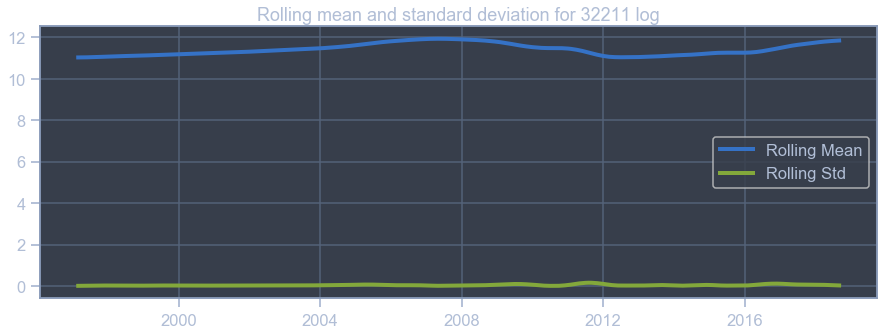

'32211 log AD Fuller test results'

Test Statistic       -2.576407
p-value               0.097972
Critical Value 1%    -3.456360
Critical Value 5%    -2.872987
Critical Value 10%   -2.572870
dtype: float64

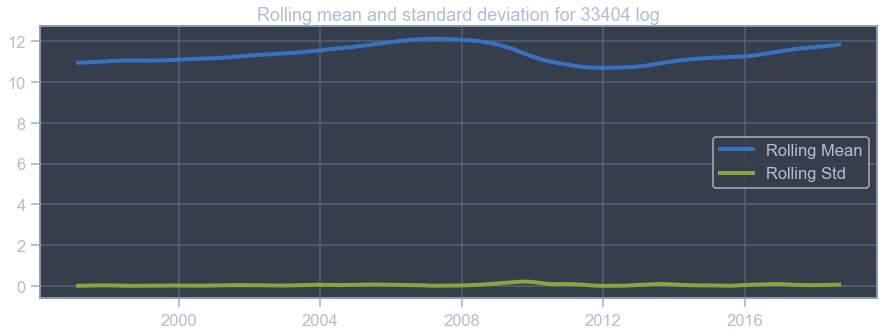

'33404 log AD Fuller test results'

Test Statistic       -3.354035
p-value               0.012629
Critical Value 1%    -3.456257
Critical Value 5%    -2.872942
Critical Value 10%   -2.572846
dtype: float64

In [27]:
metro_diffed = {}
for name, timeseries in high_zip.iteritems():
    diff = np.log(timeseries)
    name = f'{name} log'
    diff.dropna(inplace=True)
    metro_diffed[name] = diff
test_show_ad(metro_diffed)

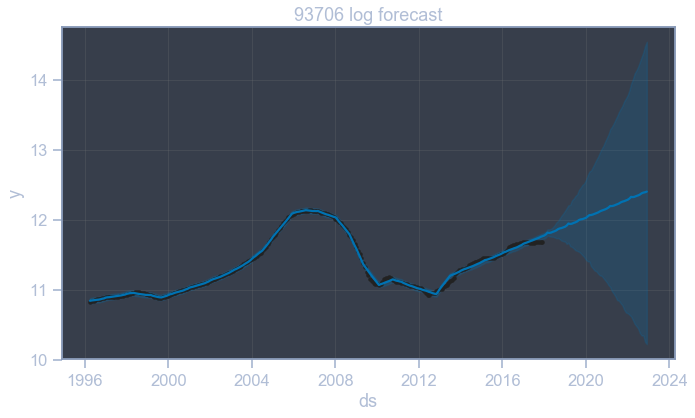

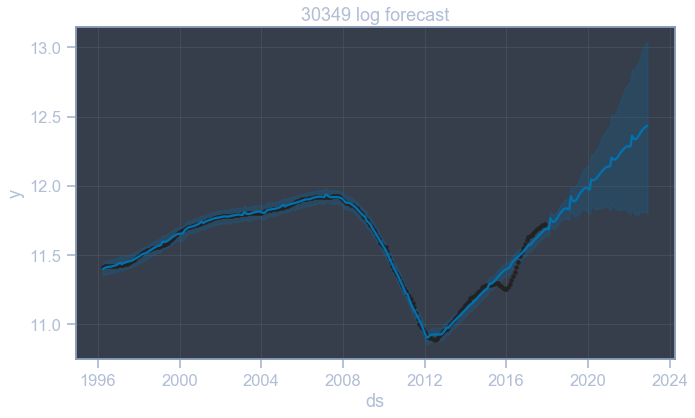

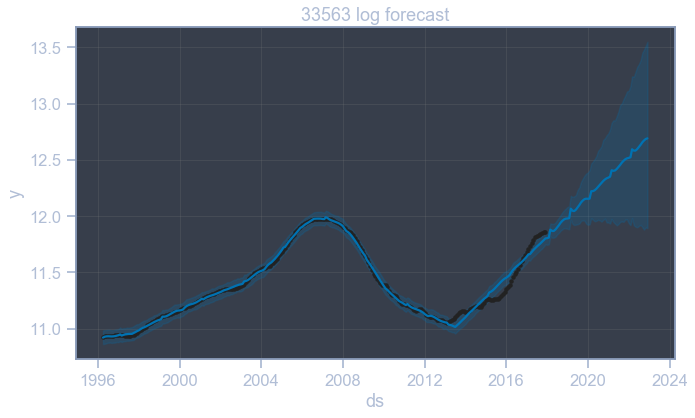

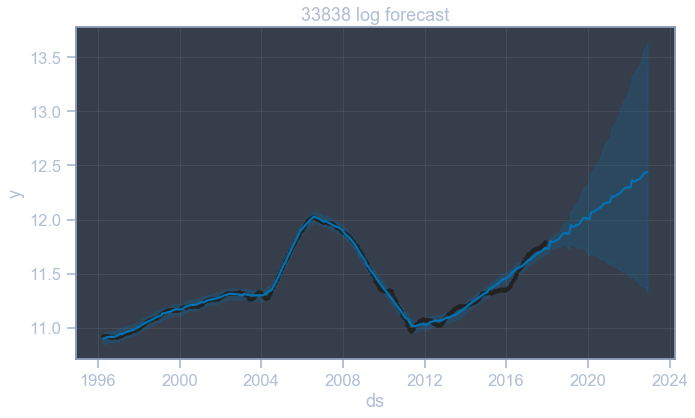

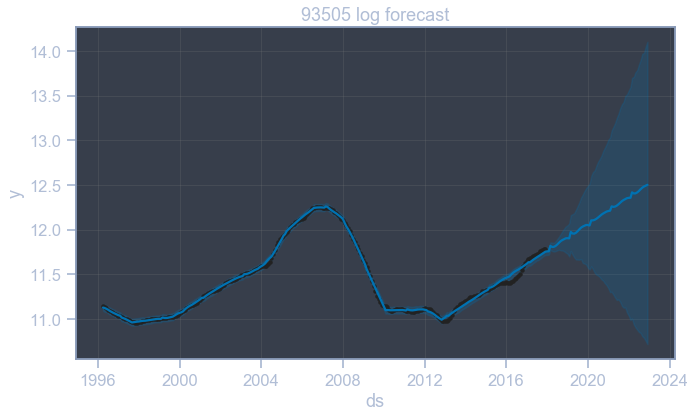

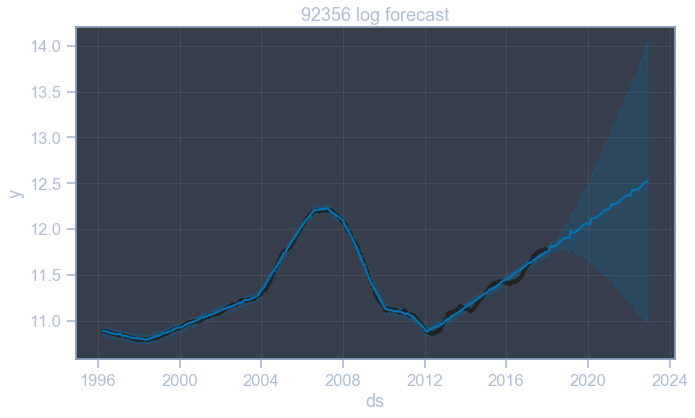

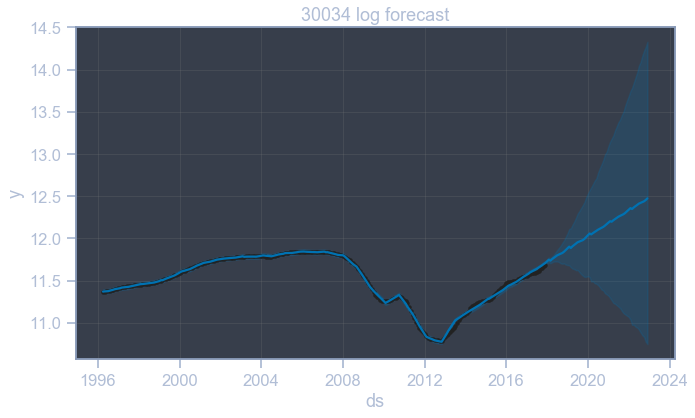

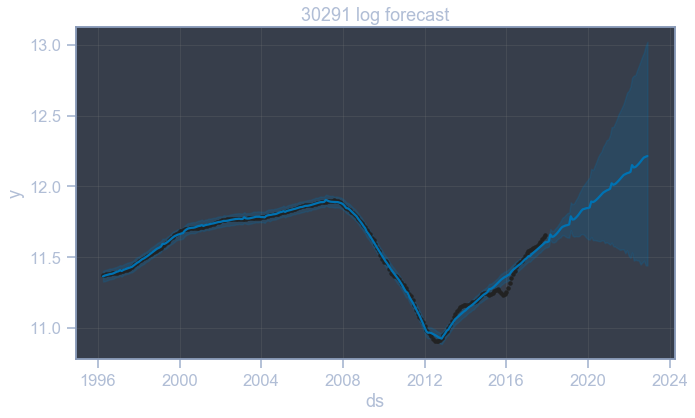

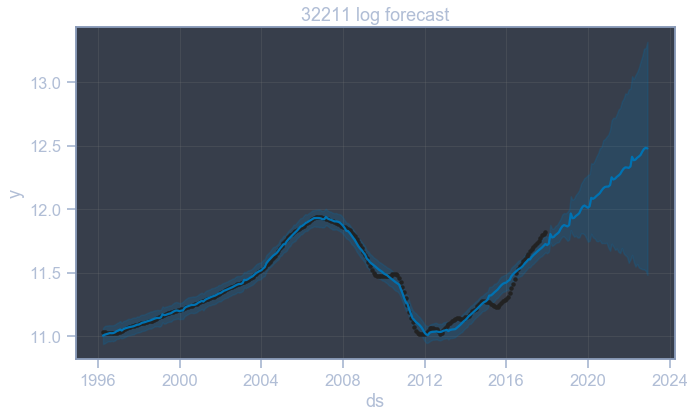

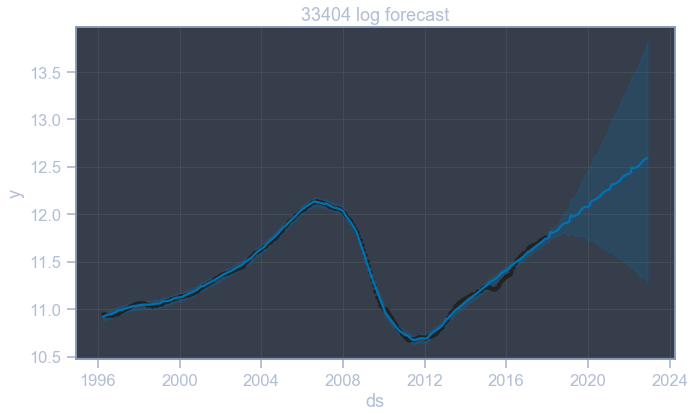

In [41]:
forecasts = {}
for name, df in metro_diffed.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df[:'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*5, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

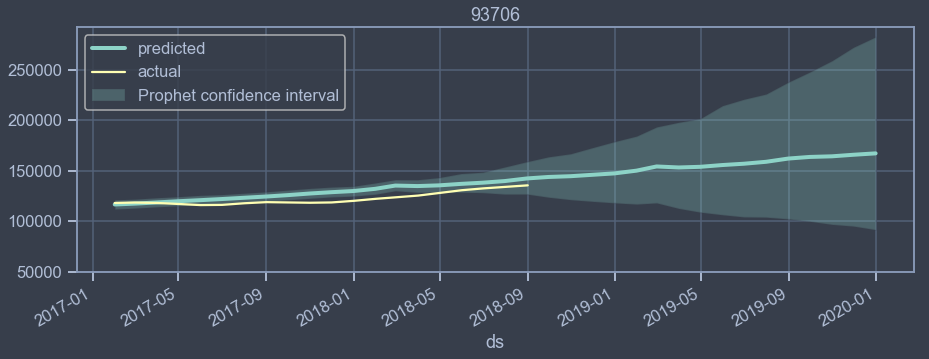

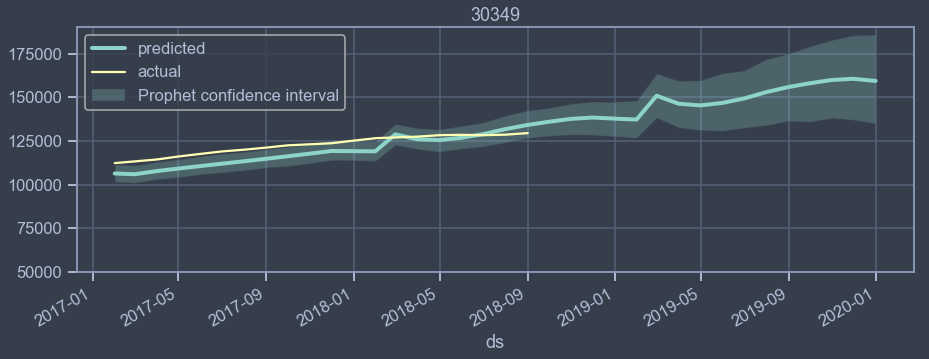

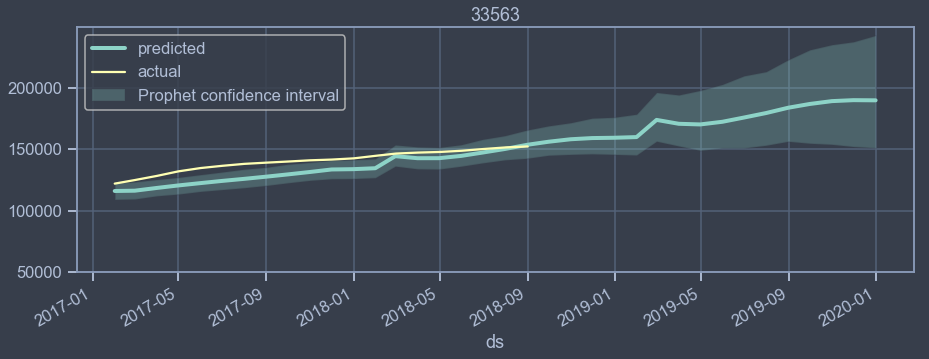

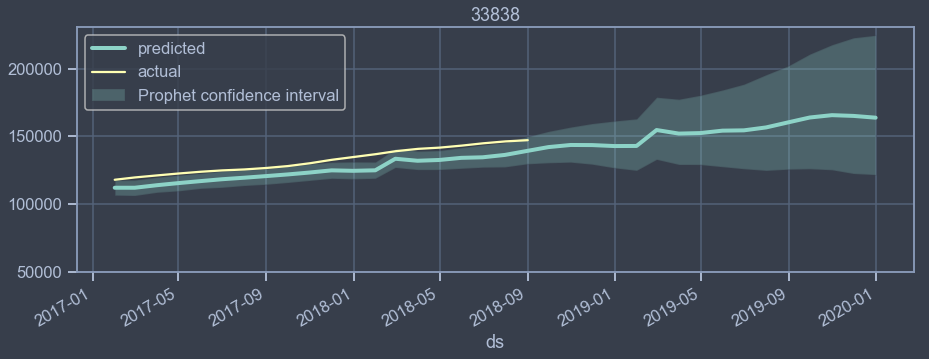

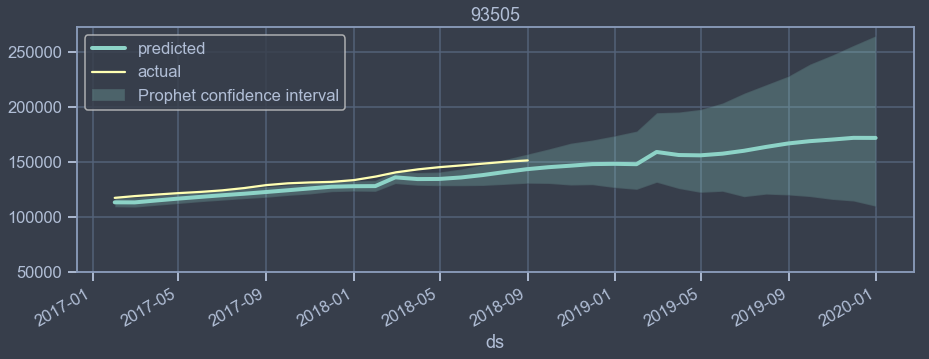

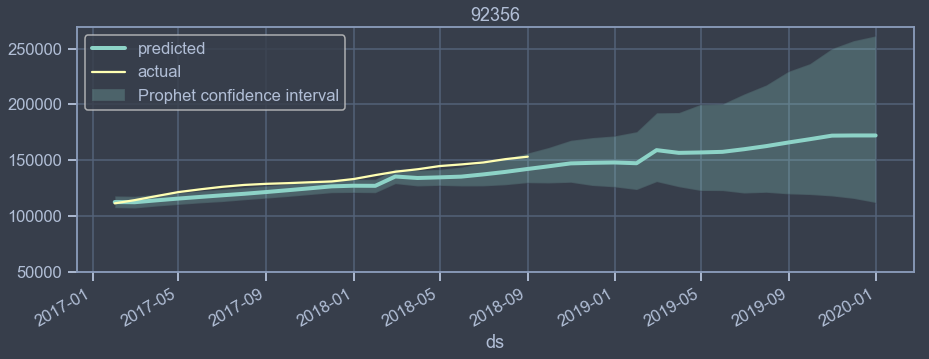

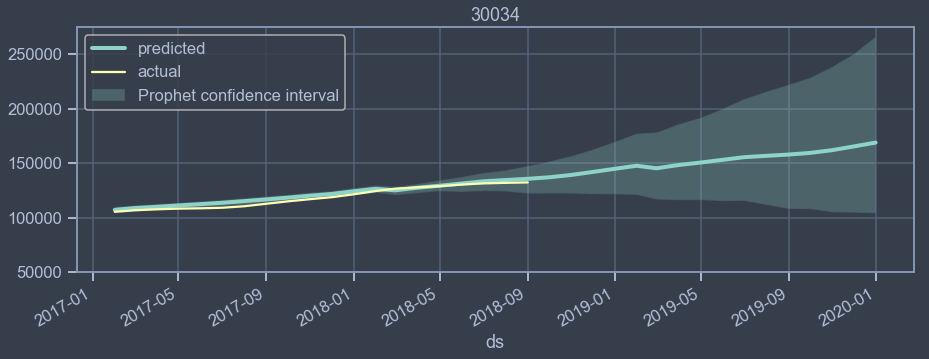

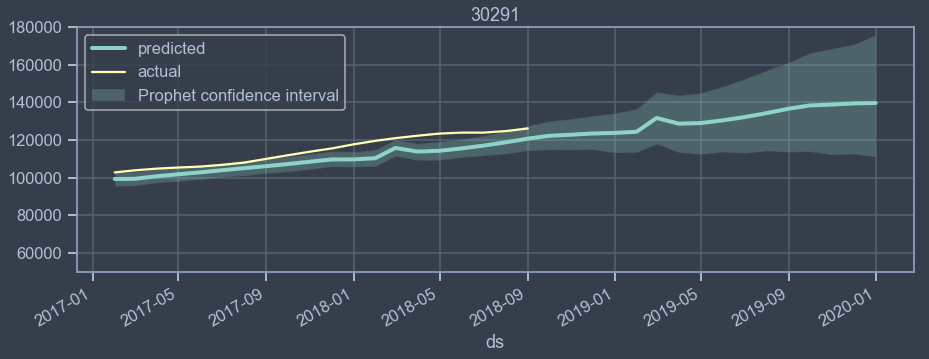

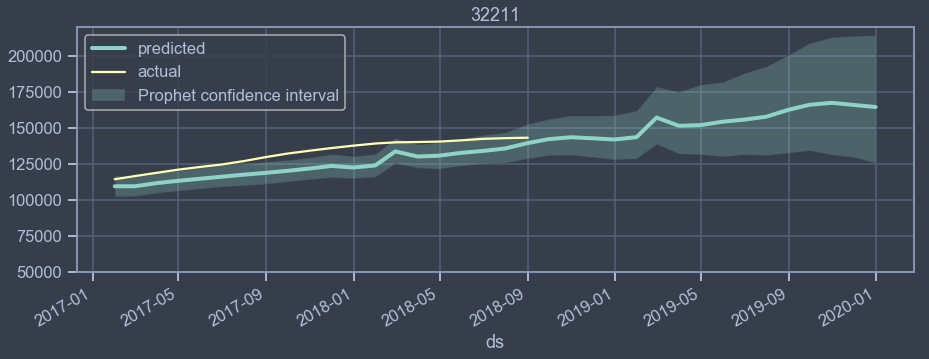

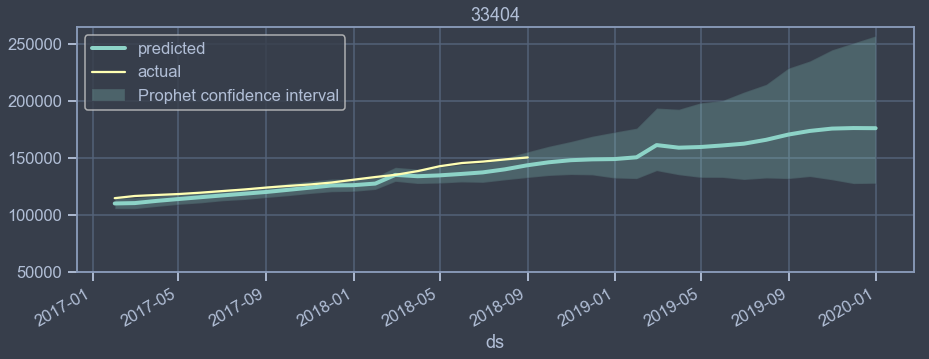

In [39]:
jtplot.style()
sns.set_context('talk')
for name, df in high_zip.iteritems():
    sns.set_palette('Set3')
    temp_2018 = df.iloc[-20:]
    _pred = forecasts[f'{name} log forecast'].loc[
        pd.to_datetime(forecasts[f'{name} log forecast'].ds) > '2017'
    ]
    _pred = _pred.loc[_pred.ds < '2020']
    ds = _pred.ds
    _pred = _pred.drop('ds', axis=1).apply(np.exp)
    _pred.columns = ['predicted', 'yhat_lower', 'yhat_upper']
    _pred = _pred.assign(ds=ds)
    _pred.set_index('ds').drop(['yhat_lower', 'yhat_upper'], axis=1).plot(
        linewidth=4,
        figsize=(15, 5)
    )
    plt.plot(temp_2018, label='actual')
    x = pd.to_datetime(ds.values)
    y = _pred.yhat_lower
    error = _pred.yhat_upper
    plt.fill_between(
        x, 
        _pred.yhat_lower,
        _pred.yhat_upper, 
        alpha=0.25,
        label='Prophet confidence interval'
    )
    plt.title(f'{name}')
    plt.legend(loc='upper left')
    plt.ylim(bottom=50000)

In [30]:
##################################################
### don't do this. it takes about an hour. #######
### not worth it. i made a csv. read from that.###
##################################################

# lat_lngs = {}
# missing = []
# counter = 0
# for zip_code in whole_enchilada.zip_code:
#     if counter %  1000 == 0:
#         print('.')
#     counter += 1
#     geocode = gmaps.geocode(zip_code)
#     if not len(geocode):
#         missing.append(zip_code)
#         continue
#     geocode = geocode[0]
#     lat_lngs[zip_code] = {
#         'lng': geocode['geometry']['location']['lng'],
#         'lat': geocode['geometry']['location']['lat']
#     }
# def fix_missing(missing):
#     counter = 0
#     for zip_code in missing:
#         if counter %  100 == 0:
#             print('.')
#         counter += 1
#         geocode = gmaps.geocode(zip_code)
#         if not len(geocode):
#             continue
#         geocode = geocode[0]
#         lat_lngs[zip_code] = {
#             'lng': geocode['geometry']['location']['lng'],
#             'lat': geocode['geometry']['location']['lat']
#         }
#         if lat_lngs[zip_code]['lng'] and lat_lngs[zip_code]['lat']:
#             print('got one')
#             missing.remove(zip_code)
# fix_missing(missing)
# print('ding, fries are done.')
# pd.DataFrame.from_dict(lat_lngs).to_csv('data/lat_lngs.csv')

#######################
### do this instead ###
#######################
lat_lngs = pd.read_csv(
    'data/lat_lngs.csv',
    usecols=['zip_code', 'lat', 'lng'],
    dtype={
        'zip_code': str
    }
)
pop_income = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
pop_income = pop_income.assign(zip_code=lambda x: x['Geography'].str.replace('ZCTA5', '').str.strip())
temp = pop_income.iloc[:, 1:3]
temp.columns = ['pop', 'income']
temp = temp.assign(zip_code=pop_income.zip_code)
whole_new = temp.copy()
temp = pd.DataFrame({'zip_code': zip_num.median().index.astype(str), 'label': zip_num.median().values})
whole_new = pd.merge(whole_new, temp)
whole_new = pd.merge(whole_new, lat_lngs)

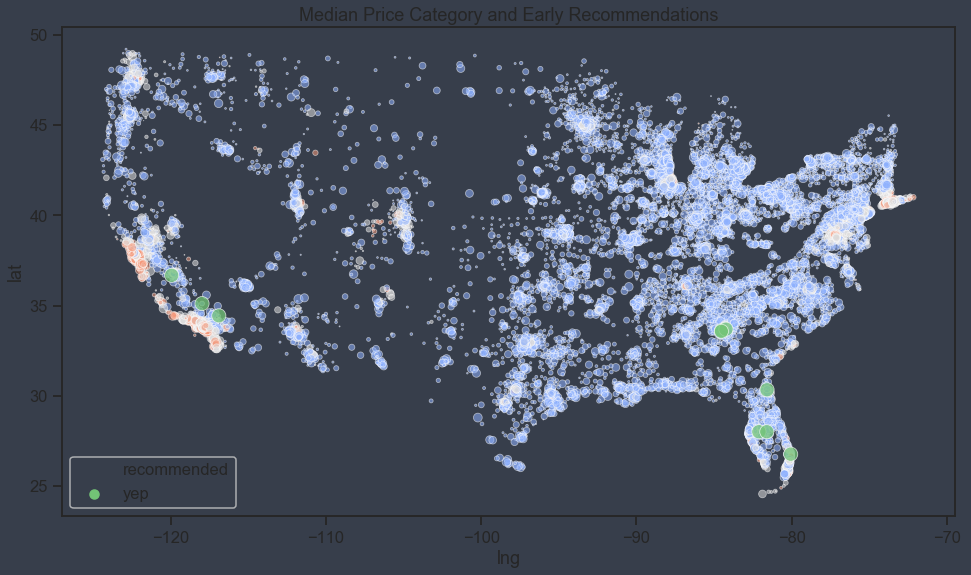

In [31]:
sns.set_style(
    'ticks',
    {
        'figure.facecolor': jtplot.base_style['figure.facecolor'],
        'axes.facecolor': jtplot.base_style['figure.facecolor']
    }
)
ll_map = whole_new.drop(whole_new.loc[whole_new.lng < -130].index)
ll_map.drop(ll_map.loc[ll_map.label < 1000].index, inplace=True)
ll_map.loc[ll_map.label >= 750000, 'label'] = 750000
ll_map.dropna(inplace=True)
ll_map['median price category'] = pd.cut(ll_map['label'], 3, labels=['low', 'mid', 'high'])
plt.figure(figsize=(16, 9))
sns.scatterplot(
    x=ll_map['lng'], y=ll_map['lat'], alpha=0.55,
    s=ll_map['pop'] / 200,
    hue=ll_map['median price category'],
    palette=('coolwarm'),
    legend=False
)
recs = pd.DataFrame.from_dict(geocode_results).T
recs = recs.assign(recommended='yep')
sns.scatterplot(
    x=recs['lng'],
    y=recs['lat'],
    s=200, alpha=.75,
    hue=recs['recommended'],
    palette='Greens',
    legend='brief'
)
plt.title('Median Price Category and Early Recommendations')
plt.legend(loc='lower left')
plt.show()